In [1]:
import qutip as qt
import numpy as np
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

from multiprocessing import Pool, cpu_count
from functools import partial
import inspect

import helperNumPy as h

In [2]:
import time
start_time = time.time()

In [3]:
(Ix, Iy, Iz) = qt.spin_J_set(1/2)
(Ip, Im) = (qt.destroy(2), qt.create(2))

#identity matrix
Id = qt.qeye(2)

#eigenvalues&vectors
vals = np.round(Iz.eigenstates()[0], 1)
vects = Iz.eigenstates()[1]

In [4]:
#This cell uses the multiprocessing package to utilize multiple CPUs
#It might be a mess to convert to a PULSEE file

def Eval(params, id):
    #helper function for  diagonalEvolve, returns only the 
    #density matrices
    import numpy as np
    import helperNumPy as h 
    rho0 = np.array(params[0])
    H =  np.array(params[1])
    
    U1, D1, D1exp = h.diagonalize(-1j*H*id)
    U2, D2, D2exp = h.diagonalize(1j*H*id)
    
    rho = U1 @ D1exp @ np.linalg.inv(U1) @ rho0 @ U2 @ D2exp @ np.linalg.inv(U2)
    return rho, id

def diagonalEvolve(func, iterable, *params):
    with open(f'./tmp_func.py', 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))

    from tmp_func import task
    
    if __name__ == '__main__':
        func = partial(task, params)
        pool = Pool() # Create a multiprocessing Pool
        res = pool.map(func, iterable)
        pool.close()
        return res
    else:
        raise "Not in Jupyter Notebook"
        
def EvalFID(params, id):
    #Gvies the form of the FID
    import numpy as np
    import helperNumPy as h 
    
    #rho0 is the initial state
    rho0 = np.array(params[0])
    #H is the Hamiltonian
    H =  np.array(params[1])
    
    Iplus =  np.array(params[2])
    #T2 forces an artificial T2 decay
    T2 = params[3]
    
    U1, D1, D1exp = h.diagonalize(-1j*H*id)
    U2, D2, D2exp = h.diagonalize(1j*H*id)
    
    rho =  U1 @ D1exp @ np.linalg.inv(U1) @ rho0 @ U2 @ D2exp @ np.linalg.inv(U2) 
    
    Ip_expect = np.trace(rho @ Iplus)*np.exp(-id/T2)
    
    return Ip_expect, id

In [5]:
def h_tensor_coupling(ten_matrix):
    # Initialize empty operator of appropriate dimension as base case for 
    # for loop. 
    h = qt.tensor(Id, Id) * 0 
    i_1 = (Ix, Iy, Iz)
    i_2 = (Ix, Iy, Iz)
    
    for m in range(len(i_1)):
        for n in range(len(i_2)):
            h += ten_matrix[m, n] * (qt.tensor(i_1[m], i_2[n]))
    return h

def CNOT_th(state):
    CNOT_gate = qt.qip.operations.cnot(2, 0, 1)

    state = np.array(CNOT_gate) @ np.array(state) @ np.array(CNOT_gate.dag())
    return state

def hadamard_theory(state):
    hadamard = qt.qip.operations.hadamard_transform(1)
    hadamard = qt.tensor(qt.qeye(2), hadamard)
    state = np.array(hadamard) @ np.array(state) @ np.array(hadamard.dag())
    return state 
    
def hadamard2_inst(initial_state):
    
    st = h.apply_pulse(initial_state, np.pi/4, qt.tensor(qt.qeye(2), Iy))
    
    st = h.apply_pulse(st, np.pi, qt.tensor(qt.qeye(2), Ix))
    
    st = h.apply_pulse(st, np.pi/4, qt.tensor(qt.qeye(2), -Iy)) 

    
    return st

def CNOT_inst(H0, j, initial_state):
    
    st = h.apply_pulse(initial_state, -np.pi/2, qt.tensor(Id, Iy))
    
    t_2 = 1/(2*j)
    
    st = diagonalEvolve(Eval, np.linspace(0, t_2, 3), st, H0)[-1][0]
    
    st = h.apply_pulse(st, -np.pi/2, qt.tensor(Id, Ix))
    
    st = h.apply_pulse(st, np.pi/2, qt.tensor(Id, Iz))

    st = h.apply_pulse(st, -np.pi/2, qt.tensor(Iz, Id)) 

    
    return st

def initialCoherent(theta=np.deg2rad(90), phi=np.deg2rad(90)):
    import qutip as qt
    from scipy.special import binom
    n = 1/2
    """"
    Prepares an initial coherent state based on the two angles \theta 
    and \phi with respect to the Iz operator in the Bloch sphere. Maximal 
    squeezing for the coherent state that is the eigenstate of +/- Ix
    operator.
    
    Inputs:
    - theta: angle in rad
    - phi: angle in rad
    
    Returns:
    - ksi: the density matrix of the squeezed state (qutip object)
    
    """
    state = vects[0] - vects[0]
    for i in range(len(vals)):
        state = state + np.sqrt(binom(2*n, n+vals[i])) *\
        (np.cos(theta/2))**(n-vals[i])*(np.sin(theta/2))**(n+vals[i]) *\
        np.exp(-1j*(n+vals[i])*phi)*vects[i]
    
    ksi = state *state.dag()
    psi = vects[0]*vects[0].dag()
#     psi = Iz
    A =-(0.5*(1/np.pi))*epsilon*B2pi*(GAMMA_2PIS[0]*qt.tensor(psi, qt.qeye(2)) + GAMMA_2PIS[1]*qt.tensor(qt.qeye(2), ksi)) + (1-epsilon)*qt.tensor(qt.qeye(2), qt.qeye(2))
    return A/A.tr()

def initialThermal():
    psi = vects[0]*vects[0].dag()
#     psi = Iz
    A =-epsilon*B2pi*(GAMMA_2PIS[0]*qt.tensor(psi, qt.qeye(2)) + GAMMA_2PIS[1]*qt.tensor(qt.qeye(2), Iz)) + (1-epsilon)*qt.tensor(qt.qeye(2), qt.qeye(2))
    return A/A.tr()

In [6]:
FOLDER = "G:\\Other computers\\My Laptop (1)\\GDrive\\Brown\\PULSEE\\\TestPulsesSymPyNumPy\\\ExampleToSend\\"

In [7]:
SIM_NAME = FOLDER +"CNOT_coh"

In [8]:
CORRELATED = False
THERMAL = True
COHERENT = False

# set up the parameters
B_0 = 10.
B2pi = 2*np.pi*B_0
GAMMA_2PIS = [2000*10, 10] 


ACQUISITION_TIME = 1200
N_POINTS = 240

T2 = 100

#thermal polarization factor 
epsilon = 1e-6
# epsilon = 10e-2

try:
    os.mkdir(SIM_NAME)
except:
    pass

In [9]:
H0 = -B2pi*GAMMA_2PIS[0]*qt.tensor(Iz, Id) -B2pi*GAMMA_2PIS[1]*qt.tensor(Id, Iz)
h_tensor_inter = 2*np.pi*np.array([[
                0.5,
                0.,
                0.05],
                [
                0.,
                0.5,
                0.],
            [
                0.05,
                0.,
                0.5]])
H_hyp = h_tensor_coupling(h_tensor_inter)

H0 += H_hyp 
h_tensor_inter

array([[3.14159265, 0.        , 0.31415927],
       [0.        , 3.14159265, 0.        ],
       [0.31415927, 0.        , 3.14159265]])

In [10]:
before_gates = None    
if COHERENT and not CORRELATED:
    psi0 = initialCoherent()

elif CORRELATED and THERMAL: 
    before_gates = initialThermal()    
    psi0 = CNOT_inst(H0, h_tensor_inter[2,2], before_gates)
    psi0 = hadamard2_inst(before_gates)
#     psi01 = CNOT_th(psi0)
    
elif THERMAL and not CORRELATED: 
    psi0 = initialThermal()
    
elif CORRELATED and COHERENT: 
    before_gates = initialCoherent()
#     psi0 = hadamard2_inst(before_gates)
    psi0 = CNOT_inst(H0, h_tensor_inter[2,2], before_gates)
#     psi0 = CNOT_th(before_gates)

In [11]:
#Evolve state for some time
st0 = diagonalEvolve(Eval, np.linspace(0, 8, 2), psi0, H0)
st0 = [i[0] for i in st0]

In [12]:
#Apply a pi/2 pulse
st2 = h.apply_pulse(st0[-1], np.pi/2,  (qt.tensor(Id, Ix)))

In [13]:
#Obtain the FID
times = np.linspace(start=0, stop=ACQUISITION_TIME, num=int(ACQUISITION_TIME*N_POINTS))
Iplus = qt.tensor(Ip, Id) + qt.tensor(Id, Ip) 

Iplus = np.array(Iplus)

Ip_rot_expect = diagonalEvolve(EvalFID, times, st2, H0, Iplus, T2)
fid = [i[0] for i in Ip_rot_expect] 

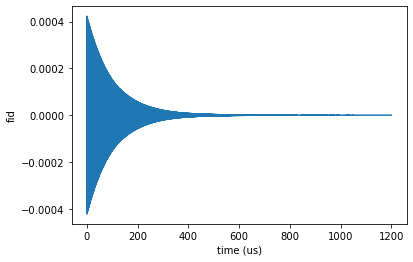

In [14]:
plt.plot(times, np.real(fid))

plt.xlabel('time (us)')

plt.ylabel('fid')
plt.savefig(SIM_NAME +'\\FIDSignal')
plt.show()

In [15]:
f, ft = h.FT_Stephen(fid, times)

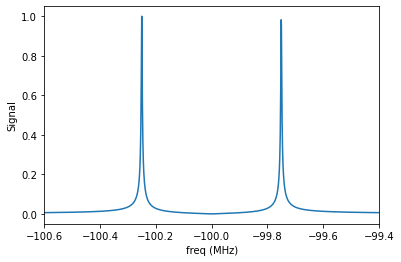

In [16]:
plt.plot(f, np.abs(ft)/np.max(np.abs(ft)))

plt.xlabel('freq (MHz)')
plt.ylabel('Signal')
plt.xlim([-100.6, -99.4])
# plt.legend()
plt.savefig(SIM_NAME +'\\FTSignal')
plt.show()

In [17]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.346596002578735 seconds ---
